# Estudo de Caso

Realizando teste para verificar o calculo de distancia entre o usuario SUS e a unidade execuntate. 

## importação de bibliotecas e dados

In [ ]:
#instalação de biblioteca (opcional)
import pip
pip.main(["install","pandas","folium","matplotlib","geopy","requests","urllib"])

In [93]:
#importação de biblioteca
import folium 
import warnings
import urllib.request
import json
import time
import requests
import geopy.distance
import pandas as pd
import matplotlib.pyplot as plt
import folium.plugins as plugins
from folium.plugins import HeatMap
from email import header
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from numpy import dtype
from collections import defaultdict, OrderedDict

In [3]:
#configurar pacotes
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#importação de dados
df_original = pd.read_csv('../SISREG_Estudo_caso-AI_FALTAS_USUARIOS/dados/DADOS_SISREG_teste.csv', 
    dtype={'CNES_EXECUTANTE':'str','IBGE_USUARIO':'str','CEP_USUARIO':'str', 'CEP_UNID_EXECUTANTE':'str'}) 
df_cep = pd.read_csv('../SISREG_Estudo_caso-AI_FALTAS_USUARIOS/dados/TABELA_CEP_BR.txt', 
    dtype=str, sep="	", header=None)
df_cep.columns = ['CEP','UF','CIDADE','BAIRRO','LOGRADOURO']


## Tratamento com os CEP's

In [5]:
#quantidade de CEP's importado
df_cep.shape

(849343, 5)

In [6]:
#criando um DataFrame somente os CEP's dos usuarios.
df_ceps_usuario = df_original['CEP_USUARIO']
df_ceps_usuario = pd.DataFrame(df_ceps_usuario)
df_ceps_usuario.drop_duplicates(inplace=True)
df_ceps_usuario.dropna(inplace=True)
df_ceps_usuario.head(5)

,CEP_USUARIO
0,89180000
1,58410080
2,89687000
3,89896000
4,89745000


In [7]:
#quantidade de CEP's localizado na base 

print("Cep's unicos de usuarios: ",df_ceps_usuario.count())

Cep's unicos de usuarios:  CEP_USUARIO    173
dtype: int64


In [8]:
#localizando endereço do usuario com a base do CEP's BR
df_ceps_usuario = pd.merge(df_ceps_usuario, df_cep, left_on=['CEP_USUARIO'],right_on=['CEP'] , how='left')


In [9]:
#criando um endereço completo para realizar pesquisa de lat e log
df_ceps_usuario["END_COMPLETO"] = df_ceps_usuario['LOGRADOURO']+ " - " + df_ceps_usuario['CIDADE']+ " - " + df_ceps_usuario['UF']
df_ceps_usuario.dropna(inplace=True)
df_ceps_usuario.head(5)

,CEP_USUARIO,CEP,UF,CIDADE,BAIRRO,LOGRADOURO,END_COMPLETO
1,58410080,58410080,PB,Campina Grande,Estação Velha,Rua João Caetano de Andrade,Rua João Caetano de Andrade - Campina Grande - PB
7,72855172,72855172,GO,Luziânia,Parque Industrial Mingone,Quadra Quadra 172,Quadra Quadra 172 - Luziânia - GO
12,72810520,72810520,GO,Luziânia,Setor Presidente Kennedy,Rua Paraná,Rua Paraná - Luziânia - GO
14,72800040,72800040,GO,Luziânia,Centro,Travessa Nirson Carneiro,Travessa Nirson Carneiro - Luziânia - GO
15,72815120,72815120,GO,Luziânia,Setor Mandu,Rua 31,Rua 31 - Luziânia - GO


In [10]:
#localizando lat e log 
locator = Nominatim(user_agent='localizacao')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
df_ceps_usuario["GEOLOCALIZADO"] = df_ceps_usuario["END_COMPLETO"].apply(geocode)
df_ceps_usuario.head(10)

,CEP_USUARIO,CEP,UF,CIDADE,BAIRRO,LOGRADOURO,END_COMPLETO,GEOLOCALIZADO
1,58410080,58410080,PB,Campina Grande,Estação Velha,Rua João Caetano de Andrade,Rua João Caetano de Andrade - Campina Grande - PB,None
7,72855172,72855172,GO,Luziânia,Parque Industrial Mingone,Quadra Quadra 172,Quadra Quadra 172 - Luziânia - GO,"(Quadra 12, Valparaíso de Goiás, Região Geográ..."
12,72810520,72810520,GO,Luziânia,Setor Presidente Kennedy,Rua Paraná,Rua Paraná - Luziânia - GO,"(Rua Paraná, São Caetano, Luziânia, Região Geo..."
14,72800040,72800040,GO,Luziânia,Centro,Travessa Nirson Carneiro,Travessa Nirson Carneiro - Luziânia - GO,None
15,72815120,72815120,GO,Luziânia,Setor Mandu,Rua 31,Rua 31 - Luziânia - GO,"(Rua 31, Vila Guará, Luziânia, Região Geográfi..."
16,72803360,72803360,GO,Luziânia,Setor Leste,Rua Antônio Vieira Filho,Rua Antônio Vieira Filho - Luziânia - GO,None
17,78552349,78552349,MT,Sinop,Jardim das Oliveiras,Rua das Dombéias,Rua das Dombéias - Sinop - MT,None
18,06815640,06815640,SP,Embu das Artes,Conjunto Habitacional Embu N,Rua Ana Moysés,Rua Ana Moysés - Embu das Artes - SP,None
20,06843140,06843140,SP,Embu das Artes,Vila Marajoara,Rua Paiaguas,Rua Paiaguas - Embu das Artes - SP,"(Rua Paiaguás, Vila Santa Clara, Jardim Pinhei..."
22,58400090,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,Rua Venâncio Neiva - Campina Grande - PB,"(Rua Venâncio Neiva, Centro, Campina Grande, R..."


In [11]:
#verificar LOCALIZAÇÃO lat e log não localizada (limpeza)
df_ceps_usuario.dropna(inplace=True)

In [12]:
#colocando a LATITUDE e LONGITUDE na tabela
df_ceps_usuario['LATITUDE_USUARIO'] = df_ceps_usuario['GEOLOCALIZADO'].apply(lambda loc: loc.latitude)
df_ceps_usuario['LONGITUDE_USUARIO'] = df_ceps_usuario['GEOLOCALIZADO'].apply(lambda loc: loc.longitude)
df_ceps_usuario.drop('END_COMPLETO', axis=1, inplace=True)
df_ceps_usuario.drop('GEOLOCALIZADO', axis=1, inplace=True)
df_ceps_usuario.head(10)

,CEP_USUARIO,CEP,UF,CIDADE,BAIRRO,LOGRADOURO,LATITUDE_USUARIO,LONGITUDE_USUARIO
7,72855172,72855172,GO,Luziânia,Parque Industrial Mingone,Quadra Quadra 172,-16.086994,-47.983412
12,72810520,72810520,GO,Luziânia,Setor Presidente Kennedy,Rua Paraná,-16.261027,-47.942692
15,72815120,72815120,GO,Luziânia,Setor Mandu,Rua 31,-16.228359,-47.911296
20,06843140,06843140,SP,Embu das Artes,Vila Marajoara,Rua Paiaguas,-23.680583,-46.865803
22,58400090,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,-7.219468,-35.883776
23,72837090,72837090,GO,Luziânia,Parque Alvorada II,Rua 75,-16.156912,-47.954593
27,06816220,06816220,SP,Embu das Artes,Parque Luíza,Rua Campo Florido,-23.646898,-46.818152
31,72815610,72815610,GO,Luziânia,Parque JK,Rua 19,-16.279330,-47.859893
32,06803040,06803040,SP,Embu das Artes,Centro,Rua do Virgílio,-23.651426,-46.848613
33,58415270,58415270,PB,Campina Grande,Jardim Paulistano,Rua Doutor Edésio Silva,-7.249646,-35.891586


In [13]:
#nomeação das colunas para usuarios
df_ceps_usuario.rename(columns={'CEP':'CEP_USUARIO', 'UF':'UF_USUARIO' , 'CIDADE':'CIDADE_USUARIO' , 'BAIRRO':'BAIRRO_USUARIO' ,'LOGRADOURO':'LOGRADOURO_USUARIO' })

,CEP_USUARIO,CEP_USUARIO,UF_USUARIO,CIDADE_USUARIO,BAIRRO_USUARIO,LOGRADOURO_USUARIO,LATITUDE_USUARIO,LONGITUDE_USUARIO
7,72855172,72855172,GO,Luziânia,Parque Industrial Mingone,Quadra Quadra 172,-16.086994,-47.983412
12,72810520,72810520,GO,Luziânia,Setor Presidente Kennedy,Rua Paraná,-16.261027,-47.942692
15,72815120,72815120,GO,Luziânia,Setor Mandu,Rua 31,-16.228359,-47.911296
20,06843140,06843140,SP,Embu das Artes,Vila Marajoara,Rua Paiaguas,-23.680583,-46.865803
22,58400090,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,-7.219468,-35.883776
23,72837090,72837090,GO,Luziânia,Parque Alvorada II,Rua 75,-16.156912,-47.954593
27,06816220,06816220,SP,Embu das Artes,Parque Luíza,Rua Campo Florido,-23.646898,-46.818152
31,72815610,72815610,GO,Luziânia,Parque JK,Rua 19,-16.279330,-47.859893
32,06803040,06803040,SP,Embu das Artes,Centro,Rua do Virgílio,-23.651426,-46.848613
33,58415270,58415270,PB,Campina Grande,Jardim Paulistano,Rua Doutor Edésio Silva,-7.249646,-35.891586


In [14]:
#quantidade de CEP's localizado na base e tratado
print("Cep's unicos de usuarios: ",df_ceps_usuario.count())

Cep's unicos de usuarios:  CEP_USUARIO          70
CEP                  70
UF                   70
CIDADE               70
BAIRRO               70
LOGRADOURO           70
LATITUDE_USUARIO     70
LONGITUDE_USUARIO    70
dtype: int64


In [15]:
df_original_c = pd.merge(df_original, df_ceps_usuario, how="inner", on="CEP_USUARIO")
df_original_c.head()

,CNS_USUARIO,IDADE_USUARIO,MUNICIPIO_USUARIO,IBGE_USUARIO,SEXO_USUARIO,RACA_COR_USUARIO,CEP_USUARIO,DESLOCAMENTO,CNES_EXECUTANTE,CEP_UNID_EXECUTANTE,ESPECIALIDADE,GRAVIDADE,DATA_ATEND,TEMPO_ESPERA,CONF_ATEND,quant,CEP,UF,CIDADE,BAIRRO,LOGRADOURO,LATITUDE_USUARIO,LONGITUDE_USUARIO
0,125371X74X7,66,LUZIANIA,521250,FEMININO,AMARELA,72855172,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,3857387,72800970,MÉDICO OFTALMOLOGISTA,"PRIORIDADE 1 - URGÊNCIA, ATENDIMENTO O MAIS RÁ...",2020-05-01,77,CONFIRMADO,1,72855172,GO,Luziânia,Parque Industrial Mingone,Quadra Quadra 172,-16.086994,-47.983412
1,14786XX69X7,61,LUZIANIA,521250,FEMININO,BRANCA,72810520,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,3857387,72800970,MÉDICO OFTALMOLOGISTA,"PRIORIDADE 1 - URGÊNCIA, ATENDIMENTO O MAIS RÁ...",2020-05-01,53,CONFIRMADO,1,72810520,GO,Luziânia,Setor Presidente Kennedy,Rua Paraná,-16.261027,-47.942692
2,725379X74X7,44,LUZIANIA,521250,FEMININO,AMARELA,72810520,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,3857387,72800970,MÉDICO OFTALMOLOGISTA,"PRIORIDADE 1 - URGÊNCIA, ATENDIMENTO O MAIS RÁ...",2020-05-01,70,CONFIRMADO,1,72810520,GO,Luziânia,Setor Presidente Kennedy,Rua Paraná,-16.261027,-47.942692
3,1521X5X63X7,14,LUZIANIA,521250,FEMININO,AMARELA,72815120,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,3857387,72800970,MÉDICO OFTALMOLOGISTA,"PRIORIDADE 1 - URGÊNCIA, ATENDIMENTO O MAIS RÁ...",2020-05-01,77,CONFIRMADO,1,72815120,GO,Luziânia,Setor Mandu,Rua 31,-16.228359,-47.911296
4,172416X96X7,1,EMBU,351500,FEMININO,AMARELA,06843140,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,7805497,06803080,MÉDICO DERMATOLOGISTA,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,4,CONFIRMADO,1,06843140,SP,Embu das Artes,Vila Marajoara,Rua Paiaguas,-23.680583,-46.865803


## Tratamento com os CNES

In [16]:
#criando um DataFrame somente os CEP's das unidades.
df_ceps_cnes = df_original_c['CEP_UNID_EXECUTANTE']
df_ceps_cnes = pd.DataFrame(df_ceps_cnes)
df_ceps_cnes.drop_duplicates(inplace=True)
df_ceps_cnes.dropna(inplace=True)
df_ceps_cnes.head(5)

,CEP_UNID_EXECUTANTE
0,72800970
4,06803080
5,58428016
11,58400290
12,78556144


In [17]:
#quantidade de CEP's localizado na base 
print("Cep's unicos de usuarios: ",df_ceps_cnes.count())

Cep's unicos de usuarios:  CEP_UNID_EXECUTANTE    13
dtype: int64


In [18]:
#localizando endereço do usuario com a base do CEP's BR
df_ceps_cnes = pd.merge(df_ceps_cnes, df_cep, left_on=['CEP_UNID_EXECUTANTE'],right_on=['CEP'] , how='left')


In [19]:
#criando um endereço completo para realizar pesquisa de lat e log
df_ceps_cnes["END_COMPLETO"] = df_ceps_cnes['LOGRADOURO']+ " - " + df_ceps_cnes['CIDADE']+ " - " + df_ceps_cnes['UF']
df_ceps_cnes.dropna(inplace=True)
df_ceps_cnes.head(5)

,CEP_UNID_EXECUTANTE,CEP,UF,CIDADE,BAIRRO,LOGRADOURO,END_COMPLETO
1,06803080,06803080,SP,Embu das Artes,Vila Carmem,Rua Ghers Stenberg Isidoro,Rua Ghers Stenberg Isidoro - Embu das Artes - SP
2,58428016,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,Rua Delmiro Gouveia - Campina Grande - PB
3,58400290,58400290,PB,Campina Grande,Centro,Rua Treze de Maio,Rua Treze de Maio - Campina Grande - PB
4,78556144,78556144,MT,Sinop,Jardim Paraíso,Avenida dos Flamboyants,Avenida dos Flamboyants - Sinop - MT
5,76966202,76966202,RO,Cacoal,Eldorado,Avenida Rosilene Xavier Transpadini,Avenida Rosilene Xavier Transpadini - Cacoal - RO


In [20]:
#localizando lat e log 
locator = Nominatim(user_agent='localizacao')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
df_ceps_cnes["GEOLOCALIZADO"] = df_ceps_cnes["END_COMPLETO"].apply(geocode)
df_ceps_cnes.head(10)

,CEP_UNID_EXECUTANTE,CEP,UF,CIDADE,BAIRRO,LOGRADOURO,END_COMPLETO,GEOLOCALIZADO
1,06803080,06803080,SP,Embu das Artes,Vila Carmem,Rua Ghers Stenberg Isidoro,Rua Ghers Stenberg Isidoro - Embu das Artes - SP,None
2,58428016,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,Rua Delmiro Gouveia - Campina Grande - PB,"(Rua Delmiro Gouveia, São José, Campina Grande..."
3,58400290,58400290,PB,Campina Grande,Centro,Rua Treze de Maio,Rua Treze de Maio - Campina Grande - PB,"(Rua Treze de Maio, Centro, Campina Grande, Re..."
4,78556144,78556144,MT,Sinop,Jardim Paraíso,Avenida dos Flamboyants,Avenida dos Flamboyants - Sinop - MT,"(Avenida dos Flamboyants, Sinop, Região Geográ..."
5,76966202,76966202,RO,Cacoal,Eldorado,Avenida Rosilene Xavier Transpadini,Avenida Rosilene Xavier Transpadini - Cacoal - RO,None
7,66080472,66080472,PA,Belém,Marco,Travessa Mariz e Barros,Travessa Mariz e Barros - Belém - PA,"(Travessa Mariz e Barros, Marco, Guamá, Belém,..."
10,78550110,78550110,MT,Sinop,Setor Comercial,Avenida das Embaúbas,Avenida das Embaúbas - Sinop - MT,"(Avenida das Embaubas, Sinop, Região Geográfic..."


In [21]:
#verificar LOCALIZAÇÃO lat e log não localizada (limpeza)
df_ceps_cnes.dropna(inplace=True)

In [22]:
#nomeação das colunas para unidades
df_ceps_cnes.rename(columns={'CEP':'CEP_CNES', 'UF':'UF_CNES' , 'CIDADE':'CIDADE_CNES' , 'BAIRRO':'BAIRRO_CNES' ,'LOGRADOURO':'LOGRADOURO_CNES' })

,CEP_UNID_EXECUTANTE,CEP_CNES,UF_CNES,CIDADE_CNES,BAIRRO_CNES,LOGRADOURO_CNES,END_COMPLETO,GEOLOCALIZADO
2,58428016,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,Rua Delmiro Gouveia - Campina Grande - PB,"(Rua Delmiro Gouveia, São José, Campina Grande..."
3,58400290,58400290,PB,Campina Grande,Centro,Rua Treze de Maio,Rua Treze de Maio - Campina Grande - PB,"(Rua Treze de Maio, Centro, Campina Grande, Re..."
4,78556144,78556144,MT,Sinop,Jardim Paraíso,Avenida dos Flamboyants,Avenida dos Flamboyants - Sinop - MT,"(Avenida dos Flamboyants, Sinop, Região Geográ..."
7,66080472,66080472,PA,Belém,Marco,Travessa Mariz e Barros,Travessa Mariz e Barros - Belém - PA,"(Travessa Mariz e Barros, Marco, Guamá, Belém,..."
10,78550110,78550110,MT,Sinop,Setor Comercial,Avenida das Embaúbas,Avenida das Embaúbas - Sinop - MT,"(Avenida das Embaubas, Sinop, Região Geográfic..."


In [23]:
#colocando a LATITUDE e LONGITUDE na tabela
df_ceps_cnes['LATITUDE_UNIDADE'] = df_ceps_cnes['GEOLOCALIZADO'].apply(lambda loc: loc.latitude)
df_ceps_cnes['LONGITUDE_UNIDADE'] = df_ceps_cnes['GEOLOCALIZADO'].apply(lambda loc: loc.longitude)
df_ceps_cnes.drop('END_COMPLETO', axis=1, inplace=True)
df_ceps_cnes.drop('GEOLOCALIZADO', axis=1, inplace=True)
df_ceps_cnes.head(10)

,CEP_UNID_EXECUTANTE,CEP,UF,CIDADE,BAIRRO,LOGRADOURO,LATITUDE_UNIDADE,LONGITUDE_UNIDADE
2,58428016,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.227300,-35.897340
3,58400290,58400290,PB,Campina Grande,Centro,Rua Treze de Maio,-7.221196,-35.885950
4,78556144,78556144,MT,Sinop,Jardim Paraíso,Avenida dos Flamboyants,-11.873144,-55.499869
7,66080472,66080472,PA,Belém,Marco,Travessa Mariz e Barros,-1.444061,-48.451163
10,78550110,78550110,MT,Sinop,Setor Comercial,Avenida das Embaúbas,-11.859557,-55.499867


In [24]:
#quantidade de CEP's localizado na base e tratado
print("Cep's unicos de usuarios: ",df_ceps_cnes.count())

Cep's unicos de usuarios:  CEP_UNID_EXECUTANTE    5
CEP                    5
UF                     5
CIDADE                 5
BAIRRO                 5
LOGRADOURO             5
LATITUDE_UNIDADE       5
LONGITUDE_UNIDADE      5
dtype: int64


In [25]:
df_original_cc = pd.merge(df_original_c, df_ceps_cnes, how="inner", on="CEP_UNID_EXECUTANTE")
df_original_cc.head()

,CNS_USUARIO,IDADE_USUARIO,MUNICIPIO_USUARIO,IBGE_USUARIO,SEXO_USUARIO,RACA_COR_USUARIO,CEP_USUARIO,DESLOCAMENTO,CNES_EXECUTANTE,CEP_UNID_EXECUTANTE,ESPECIALIDADE,GRAVIDADE,DATA_ATEND,TEMPO_ESPERA,CONF_ATEND,quant,CEP_x,UF_x,CIDADE_x,BAIRRO_x,LOGRADOURO_x,LATITUDE_USUARIO,LONGITUDE_USUARIO,CEP_y,UF_y,CIDADE_y,BAIRRO_y,LOGRADOURO_y,LATITUDE_UNIDADE,LONGITUDE_UNIDADE
0,176541XX5X7,33,CAMPINA GRANDE,250400,FEMININO,BRANCA,58400090,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,-7.219468,-35.883776,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734
1,76455XX18X7,55,CAMPINA GRANDE,250400,FEMININO,INDEFENIDA,58400090,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,-7.219468,-35.883776,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734
2,6X568XXX4X7,52,CAMPINA GRANDE,250400,MASCULINO,AMARELA,58410387,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58410387,PB,Campina Grande,Catolé,Rua Gilson Marinho da Silva,-7.230878,-35.905235,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734
3,957974X12X7,62,CAMPINA GRANDE,250400,FEMININO,AMARELA,58430118,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58430118,PB,Campina Grande,Bodocongó,Rua Pedro Marcelino Diniz,-7.229325,-35.917476,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734
4,9X34X9XXXX7,3,CAMPINA GRANDE,250400,MASCULINO,AMARELA,58417763,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58417763,PB,Campina Grande,Presidente Médici,Rua José Galdino dos Santos,-7.257689,-35.910645,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734


## Calculando distancia (usuario x unidade executante)

In [26]:
#calcular a distancia da unidade executante e USUARIO (LAT E LON)
for idx, row in df_original_cc.iterrows():
    coord_usuario = (row.LATITUDE_USUARIO, row.LONGITUDE_USUARIO)
    coord_unidadeEXE = (row.LATITUDE_UNIDADE, row.LONGITUDE_UNIDADE)

    df_original_cc.at[idx, "DISTANCIA_KM_USUARIO_UNIDADESOL"] = round(geopy.distance.distance(coord_usuario,coord_unidadeEXE).km, 2)

## Analisando dados tratados

In [27]:
df_original_cc.head(5)

,CNS_USUARIO,IDADE_USUARIO,MUNICIPIO_USUARIO,IBGE_USUARIO,SEXO_USUARIO,RACA_COR_USUARIO,CEP_USUARIO,DESLOCAMENTO,CNES_EXECUTANTE,CEP_UNID_EXECUTANTE,ESPECIALIDADE,GRAVIDADE,DATA_ATEND,TEMPO_ESPERA,CONF_ATEND,quant,CEP_x,UF_x,CIDADE_x,BAIRRO_x,LOGRADOURO_x,LATITUDE_USUARIO,LONGITUDE_USUARIO,CEP_y,UF_y,CIDADE_y,BAIRRO_y,LOGRADOURO_y,LATITUDE_UNIDADE,LONGITUDE_UNIDADE,DISTANCIA_KM_USUARIO_UNIDADESOL
0,176541XX5X7,33,CAMPINA GRANDE,250400,FEMININO,BRANCA,58400090,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,-7.219468,-35.883776,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734,1.73
1,76455XX18X7,55,CAMPINA GRANDE,250400,FEMININO,INDEFENIDA,58400090,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,-7.219468,-35.883776,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734,1.73
2,6X568XXX4X7,52,CAMPINA GRANDE,250400,MASCULINO,AMARELA,58410387,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58410387,PB,Campina Grande,Catolé,Rua Gilson Marinho da Silva,-7.230878,-35.905235,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734,0.96
3,957974X12X7,62,CAMPINA GRANDE,250400,FEMININO,AMARELA,58430118,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58430118,PB,Campina Grande,Bodocongó,Rua Pedro Marcelino Diniz,-7.229325,-35.917476,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734,2.24
4,9X34X9XXXX7,3,CAMPINA GRANDE,250400,MASCULINO,AMARELA,58417763,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58417763,PB,Campina Grande,Presidente Médici,Rua José Galdino dos Santos,-7.257689,-35.910645,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.2273,-35.89734,3.67


In [28]:
df_original_cc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 18
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CNS_USUARIO                      19 non-null     object 
 1   IDADE_USUARIO                    19 non-null     int64  
 2   MUNICIPIO_USUARIO                19 non-null     object 
 3   IBGE_USUARIO                     19 non-null     object 
 4   SEXO_USUARIO                     19 non-null     object 
 5   RACA_COR_USUARIO                 19 non-null     object 
 6   CEP_USUARIO                      19 non-null     object 
 7   DESLOCAMENTO                     19 non-null     object 
 8   CNES_EXECUTANTE                  19 non-null     object 
 9   CEP_UNID_EXECUTANTE              19 non-null     object 
 10  ESPECIALIDADE                    19 non-null     object 
 11  GRAVIDADE                        19 non-null     object 
 12  DATA_ATEND              

In [29]:
df_original_cc.count()

CNS_USUARIO                        19
IDADE_USUARIO                      19
MUNICIPIO_USUARIO                  19
IBGE_USUARIO                       19
SEXO_USUARIO                       19
RACA_COR_USUARIO                   19
CEP_USUARIO                        19
DESLOCAMENTO                       19
CNES_EXECUTANTE                    19
CEP_UNID_EXECUTANTE                19
ESPECIALIDADE                      19
GRAVIDADE                          19
DATA_ATEND                         19
TEMPO_ESPERA                       19
CONF_ATEND                         19
quant                              19
CEP_x                              19
UF_x                               19
CIDADE_x                           19
BAIRRO_x                           19
LOGRADOURO_x                       19
LATITUDE_USUARIO                   19
LONGITUDE_USUARIO                  19
CEP_y                              19
UF_y                               19
CIDADE_y                           19
BAIRRO_y    

## Gerando arquivo com os dados tratados 

In [30]:
display(df_original_cc)

,CNS_USUARIO,IDADE_USUARIO,MUNICIPIO_USUARIO,IBGE_USUARIO,SEXO_USUARIO,RACA_COR_USUARIO,CEP_USUARIO,DESLOCAMENTO,CNES_EXECUTANTE,CEP_UNID_EXECUTANTE,ESPECIALIDADE,GRAVIDADE,DATA_ATEND,TEMPO_ESPERA,CONF_ATEND,quant,CEP_x,UF_x,CIDADE_x,BAIRRO_x,LOGRADOURO_x,LATITUDE_USUARIO,LONGITUDE_USUARIO,CEP_y,UF_y,CIDADE_y,BAIRRO_y,LOGRADOURO_y,LATITUDE_UNIDADE,LONGITUDE_UNIDADE,DISTANCIA_KM_USUARIO_UNIDADESOL
0,176541XX5X7,33,CAMPINA GRANDE,250400,FEMININO,BRANCA,58400090,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,-7.219468,-35.883776,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.227300,-35.897340,1.73
1,76455XX18X7,55,CAMPINA GRANDE,250400,FEMININO,INDEFENIDA,58400090,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58400090,PB,Campina Grande,Centro,Rua Venâncio Neiva,-7.219468,-35.883776,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.227300,-35.897340,1.73
2,6X568XXX4X7,52,CAMPINA GRANDE,250400,MASCULINO,AMARELA,58410387,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58410387,PB,Campina Grande,Catolé,Rua Gilson Marinho da Silva,-7.230878,-35.905235,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.227300,-35.897340,0.96
3,957974X12X7,62,CAMPINA GRANDE,250400,FEMININO,AMARELA,58430118,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58430118,PB,Campina Grande,Bodocongó,Rua Pedro Marcelino Diniz,-7.229325,-35.917476,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.227300,-35.897340,2.24
4,9X34X9XXXX7,3,CAMPINA GRANDE,250400,MASCULINO,AMARELA,58417763,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58417763,PB,Campina Grande,Presidente Médici,Rua José Galdino dos Santos,-7.257689,-35.910645,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.227300,-35.897340,3.67
5,X38354X76X7,33,CAMPINA GRANDE,250400,FEMININO,PRETA,58406536,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58406536,PB,Campina Grande,Nova Brasília,Rua Antônio Jerônimo da Silva,-7.215383,-35.855596,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.227300,-35.897340,4.79
6,X94256X68X7,82,CAMPINA GRANDE,250400,FEMININO,PARDA,58408072,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362848,58428016,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58408072,PB,Campina Grande,Vila Cabral,Rua São Luiz,-7.176637,-35.979719,58428016,PB,Campina Grande,Centenário,Rua Delmiro Gouveia,-7.227300,-35.897340,10.69
7,2347X4X89X7,25,CAMPINA GRANDE,250400,MASCULINO,PARDA,58415270,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362821,58400290,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58415270,PB,Campina Grande,Jardim Paulistano,Rua Doutor Edésio Silva,-7.249646,-35.891586,58400290,PB,Campina Grande,Centro,Rua Treze de Maio,-7.221196,-35.885950,3.21
8,854322X67X7,11,CAMPINA GRANDE,250400,MASCULINO,AMARELA,58436220,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2362821,58400290,FONOAUDIÓLOGO,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,58436220,PB,Campina Grande,Serrotão,Rua Aristides Olímpio Maia,-7.213300,-35.948969,58400290,PB,Campina Grande,Centro,Rua Treze de Maio,-7.221196,-35.885950,7.01
9,252284XX5X7,18,SINOP,510790,FEMININO,AMARELA,78555022,ATENDIDO NO MESMO MUNICIPIO DE RESIDENCIA DO U...,2795671,78556144,MÉDICO GINECOLOGISTA E OBSTETRA,PRIORIDADE 3 - ATENDIMENTO ELETIVO,2020-05-01,0,CONFIRMADO,1,78555022,MT,Sinop,Jardim Impe

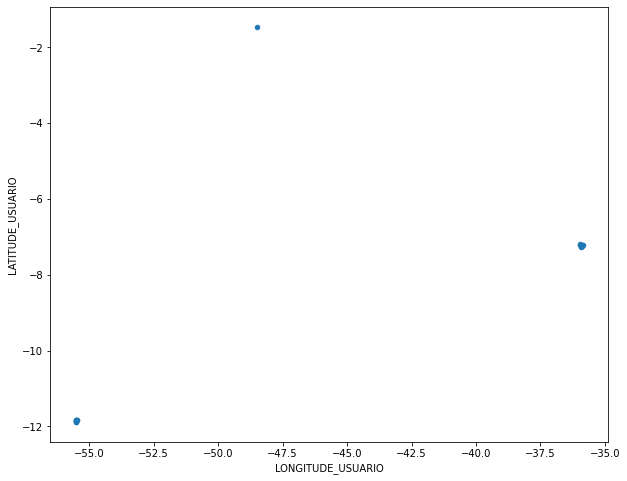

In [73]:
geo_teste = df_original_cc.plot.scatter(y='LATITUDE_USUARIO', x='LONGITUDE_USUARIO', figsize=(10,8))

In [86]:
coordenadas= df_original_cc[['LATITUDE_USUARIO','LONGITUDE_USUARIO','ESPECIALIDADE']]

In [87]:
coordenadas = coordenadas.dropna()

In [97]:
baseMap = folium.Map(
    width= "100%", #800
    height=  "100%", #600
    location=[-15.77972,-47.92972],
    zoom_start=4
)

In [ ]:
baseMap = baseMap.add_child(plugins.HeatMap(coordenadas))

In [98]:
baseMap